In [2]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')
import scipy.stats as stats
import scipy
import pandas as pd

<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=default"></script>
# 数据预处理

**数据清理，数据聚合，数据降维，数据变换**

## 数据清理
### 缺失值
* **直接删除**：适用于数据量特别少的情况，比如1%
* **人工填写缺失值**：适用于数据量特别少，比如10个，20个。或者有其他非缺失的数据集，结合业务关系，从而填充缺失值。
* **使用全局变量填充**：比如-999，-1
* **使用属性的中心度量填充**：对于对称分布，使用均值，对于有偏分布，使用中位数。
* **使用给定分类的相关中心度量填充**：对于分好类的数据，利用一类中的相关样本的中心度量填充。
* **模型填充**：使用非缺失值，结合回归模型，决策树等基本模型来预测缺失值

### 噪声数据
光滑数据，去除噪声

* **分箱**：比如现有数据[[4,8,15],[21,21,25],[25,28,34]]。均值分箱，[[9,9,9],[22,22,22],[29,29,29]]；中位数分箱，[[8,8,8],[21,21,21],[28,28,28]]；箱边界分箱，非箱边界值，跟箱哪边接近就用哪边[[4,4,15],[21,21,24],[25,25,34]]。
* **回归**：使用一个函数来光滑数据。
* **离群点分析**：使用聚类，决策树等方法来检测离群点。
<img src="images/异常方法对比.png" style="zoom:50%;" />

* **Robust covariance**：即基于方差的鲁棒的异常检测模型，在sklearn中是covariance.ELLipticEnvelope。该模型假设正常样本都服从高斯分布。显然，对上图所示的二维数据集，covariance.ELLipticEnvelope采用二维的椭圆拟合正常样本。
* **One-Class SVM**：即单类别的SVM，在sklearn中是svm.OneClassSVM，从上图可以看到该模型的边界都是弯弯曲曲的，说明one-class svm具有很强的拟合能力，但这也导致了它对训练集中对噪声点很敏感。**适合用于异常点检测**
* **Isolation Forest**：孤立森林，在sklearn中是ensemble.IsolationForest，它在上图中数据集中的异常检测效果都不错。
* **Local Outlier Factor**：，即局部异常因子检测算法，又称LOF，在sklearn中是neighbors.LocalOutlierFactor，效果也不错。

## 数据集成
### 冗余和相关分析

* **类别数据的$\chi^2$检验**：对于A，B两个类别数据，可以通过卡方检验来实现，是**类别数据的不同值**，而不是所有值，**并且卡方检验假设A，B条件独立**。

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.datasets import load_iris
 
#导入IRIS数据集
iris = load_iris()
#iris.data#查看数据

In [28]:
model1 = SelectKBest(chi2, k=2)#选择k个最佳特征
tmp = model1.fit_transform(iris.data, iris.target)#iris.data是特征数据，iris.target是标签数据，该函数可以选择出k个特征 

可以看出后使用卡方检验，选择出了后两个特征。如果我们还想查看卡方检验的p值和得分，可以使用第3步。

In [25]:
model1.scores_

array([ 10.81782088,   3.7107283 , 116.31261309,  67.0483602 ])

In [26]:
model1.pvalues_

array([4.47651499e-03, 1.56395980e-01, 5.53397228e-26, 2.75824965e-15])

可以看出后两个特征的p值最小，置信度也最高，与前面的结果一致。查表以便得到是否满足假设检验。

[sklearn.feature_selection.SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)

class sklearn.feature_selection.SelectKBest(score_func= function_f_classif, k=10)

网站里面还可以使用很多种内置函数

**f_classif**
    ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**
    Mutual information for a discrete target.

**chi2**
    Chi-squared stats of non-negative features for classification tasks.

**f_regression**
    F-value between label/feature for regression tasks.

**mutual_info_regression**
    Mutual information for a continuous target.

**SelectPercentile**
    Select features based on percentile of the highest scores.

**SelectFpr**
    Select features based on a false positive rate test.

**SelectFdr**
    Select features based on an estimated false discovery rate.

**SelectFwe**
    Select features based on family-wise error rate.

**GenericUnivariateSelect**
    Univariate feature selector with configurable mode.

* **数值类型的相关系数**；$Pearson$相关系数
相关系数越高，越接近1，则说明相关数据有冗余。若小于0，则A，B是负相关的，一个值增加另一个值就减少。

相关性不代表因果性：比如一个地区的医院数与汽车盗窃是相关的，但是这是因为两个都与人口有关。

In [46]:
tmp = pd.DataFrame({'0':np.random.randn(10),'1':np.random.randn(10)})
tmp.corr()   # 相关系数

,0,1
0,1.000000,-0.267551
1,-0.267551,1.000000


* **数值类型的协方差**：对于A，B两个数据，协方差为**正**，即如果A大于Mean(A)，则B很可能大于Mean(B)。若A小于Mean(A)，则B大于Mean(B)，就为**负**。

In [48]:
tmp.cov()   # 协方差

,0,1
0,0.969751,-0.219577
1,-0.219577,0.694545


## 数据降维

* **删除**：直接删除冗余的特征
* **数量降维**：使用直方图法，聚类，抽样，数据立方体聚集
* **数据压缩**：小波变换, PCA，属性子集选择（树模型）

### 数量降维
* **直方图**：将一些列数据，分块，放入桶中，一个桶代表连续一片连续值域。将桶中的数据，转化为桶中**计数**表示。
    * **等宽**：宽度区间都是一样的。
    * **等频**：每个桶的频率粗略的相等。（没理解到意思）
对于**近似稀疏和稠密数据，以及高倾斜和均匀的数据**，直方图非常有效。甚至可以推广到多个属性。比如3维直方图，能够表现属性之间的依赖

* **聚类**：KMeans，层次分类，密度分类。

* **抽样**：用数据量较小的随机样本代替全部数据，维度越高，抽样的影响越大。影响越小越好
    * **有放回简单随机抽样**，**无放回简单随机抽样**
    * **簇抽样**：基于数据块
    * **分层抽样**：基于类别
<img src="images/抽样方法.png" style="zoom:50%;" />

* **数据立方体**：基于时间增加通道（CNN中通道，一个概念）

In [5]:
# 不放回抽样
import random
random.sample(range(100),10) 

[83, 28, 48, 97, 61, 25, 91, 17, 95, 12]

In [9]:
# 放回抽样
idxBag = []
nBagSamples=50
for i in range(10):  # 抽样次数
    idxBag.append(np.random.choice(range((10))))
idxBag

[1, 9, 9, 0, 2, 0, 6, 0, 7, 7]

In [10]:
# 类别抽样方法类似，固定类别而已

### 数据压缩
* **小波变换**：适用于高维数据：图像压缩，时间序列数据分析（股票），数据清理
* **PCA**：稀疏数据和倾斜数据

In [1]:
import pywt # 小波变换包
#PCA 在Sklearn中有

### 数据变换与数据离散化

数据变换中，将数据变为同一或者适合挖掘的形式。简化了数据，使数据挖掘更有效
* **光滑**：去除数据中的噪声。包括分箱，回归和聚类。
* **特征构造**：比如BMI指数
* **聚集**：对数据进行汇总或者聚集。比如DataFrame的agg函数，针对到业务：就是每天有多少消费记录，聚集到一个月有多少。
* **规范化**：特征缩放，比如MinMaxScaler，StandardScaler。
* **离散化**：将数值属性转化为原始值的区间标签，概念标签，聚类、决策树、相关分析。比如年龄，成绩
* **由类别数据产生概念分层**：目前理解：将一个特征转为两个分成的特征。
<img src="images/概念分层.jpg" style="zoom:50%" />

**规范化**：
* 最大最小化，归一化
    $$X = \frac{X - min(X)}{max(X) - min(X)}$$
* 标准化，正态化
    $$X = \frac{X - mean(X)}{std(X)} $$
    此处的$std(X)$可以用均值绝对偏差$S_X$代替
    $$ S_X = \frac{1}{n}(|v_1 - \bar{A}|+|v_2 - \bar{A}|+\cdots+|v_n - \bar{A}|)$$
    
* 小数定标
    就是将整数转为小数

In [21]:
# 归一化
from sklearn.preprocessing import MinMaxScaler
data = [[1],[2],[3],[5],[6]]
scaler = MinMaxScaler(feature_range=(0, 1))
print(scaler.fit_transform(data))

print(scaler.data_max_)

[[0. ]
 [0.2]
 [0.4]
 [0.8]
 [1. ]]
[6.]


In [29]:
# 标准
from sklearn.preprocessing import StandardScaler
data = [[1],[2],[3],[5],[6]]
scaler = StandardScaler()
print(scaler.fit_transform(data))

print(scaler.mean_,scaler.scale_)

[[-1.29399328]
 [-0.75482941]
 [-0.21566555]
 [ 0.86266219]
 [ 1.40182605]]
[3.4] [1.8547237]


In [34]:
# 小数规约
data = np.array([[1],[2],[3],[5],[60]])
data / 100

array([[0.01],
       [0.02],
       [0.03],
       [0.05],
       [0.6 ]])

**分箱离散化、 直方图离散化**

**聚类、决策树和相关分析**
    
     聚类、决策树后面讲
相关分析：$ChiMerge$是一种基于$\chi^2$的离散化方法。递归找出最邻近的区间，然后合并，形成较大的区间。与决策树模型一样，是监督模型。

过程如下：
* 把数值属性A的每个**不同值**看作一个区间。
* 对于每个相邻区间进行$\chi^2$检验。
* 具有最小 $\chi^2$ 值的相邻区间合并在一起，因为低$\chi^2$值表示又相似的类分布。
* 直到满足终止条件

## 习题
<img src="images/作业1.png" style="zoom:50%"/>

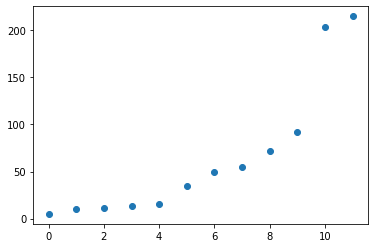

In [38]:
k = [5,10,11,13,15,35,50,55,72,92,204,215]
x = list(range(12))
plt.scatter(x,k)